<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-датасета" data-toc-modified-id="Подготовка-датасета-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка датасета</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Проверка-качества" data-toc-modified-id="Проверка-качества-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка качества</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Распознавание авторства картины be like распознавание лиц

Ежегодно из частных коллекций публикуются множество старых картин, однако установить авторство или подтвердить подлинность не всегда представляется возможным. Необходимо построить CV модель, которая облегчит эту процедуру.

В распоряжении набор картин с указанием авторства, не менее 100 на одного

## Подготовка датасета

In [1]:
import gdown

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

import os
from PIL import Image
from tqdm import notebook
from sklearn.manifold import TSNE
import pickle

Спаршенный датасет с [сайта](https://gallerix.ru/storeroom/) разбит на 2 части.

* dataset_model содержит 208 авторов и будет использоваться для обучения модели CV,

* dataset_test содержит 10 авторов, которых нет в dataset_model и будет использоваться для проверки адекватности модели на новых данных.

In [2]:
url = 'url_adress_here'
output = 'dataset_test.zip'
gdown.download(url, output, quiet=False)

url = 'url_adress_here'
output = 'dataset_model.zip'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1uG9xoFoaWXmlgBPsTLCRwr0vQuZZOX1c
To: /content/dataset_test.zip
100%|██████████| 246M/246M [00:03<00:00, 67.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lxTwWUTBvquKnnLD_QPSoyvy4avKJmfs
To: /content/dataset_model.zip
100%|██████████| 4.71G/4.71G [00:45<00:00, 103MB/s] 


'dataset_model.zip'

In [ ]:
! unzip -qq dataset_test.zip
! unzip -qq dataset_model.zip

In [4]:
def img_count(root):
    num_auth = 0
    num_img = 0

    for dirname, _, files in os.walk(root):
        if dirname == root:
            continue
        num_auth += 1
        num_img += len(files)
    return num_auth, num_img

In [5]:
img_count('dataset_model')

(208, 43759)

In [6]:
img_count('dataset_test')

(10, 1988)

В обучающем датасете 43 тыс картин, этого должно хватить для обучния простых моделей типа resnet-18, однако следует учитывать, что модель будет распознавать не стиль, а авторство, поэтому ожидать высокого accuracy не следует.



In [7]:
resnet_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])

In [8]:
data = datasets.ImageFolder('./dataset_model', transform=resnet_transforms)

In [9]:
train_data, val_data, test_data = torch.utils.data.random_split(data, [0.8, 0.1, 0.1])

In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Отрисуем немного картин чтобы понять с чем мы работаем

In [11]:
for batch in test_loader:
    images, labels = batch
    break

In [12]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    
    for i, axis in enumerate(axes):
        img = images[i].numpy()
        img = np.transpose(img, (1, 2, 0))
        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())
    plt.show()

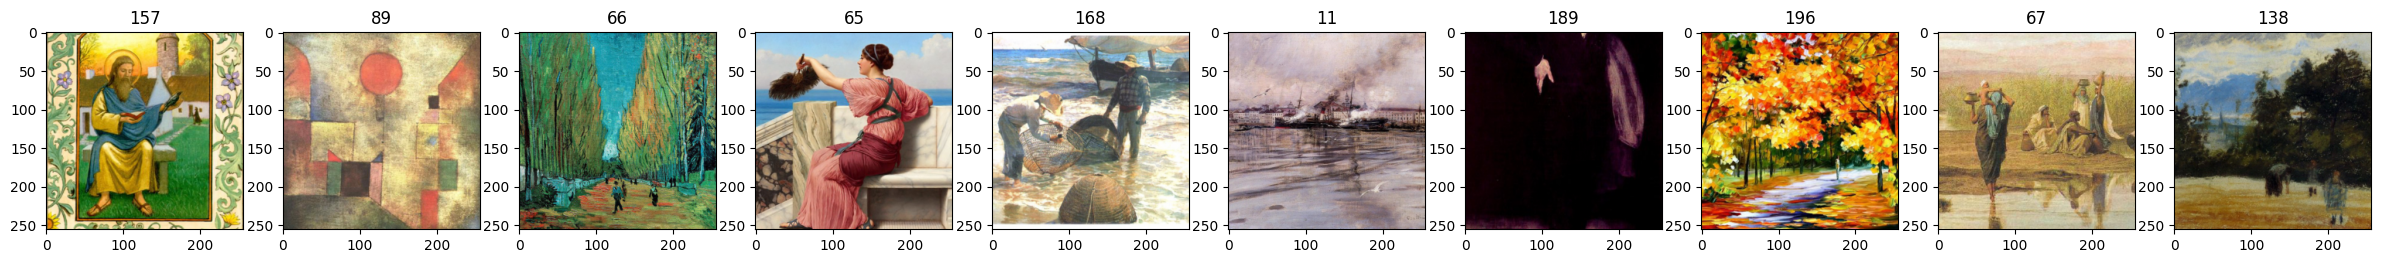

In [13]:
show_images(images, labels)

Картины приведены к квадрату обрезанием, цвета оригинальные

## Обучение модели

Модели распознавания строятся по 2 принципам:
1. Обучается модель классификации, у которых в дальнейшем удаляется последний слой, а идентификация принадлежности происходит по ближайшим соседям в векторном пространстве.
2. Модель сразу обучается по метрике l3 как можно дальше разносить авторов, этот подход будет реализован позже

За основу возьмем предобученный resnet18 заменим последний слой на fc(512x512), и добавим слой out(512x208). Обучать будем 10 эпох, после каждой будем сохранять модель и фиксировать accuracy, после будем тестировать лучшую.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
def evaluate(model, dataloader, loss_fn):
    
    losses = []
    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):
        X_batch, y_batch = batch
        num_elements += len(y_batch)
        
        with torch.no_grad():
            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            y_pred = torch.argmax(logits, dim=1)
            
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    
    accuracy = num_correct / num_elements   
    return accuracy.numpy(), np.mean(losses)


def train(model, loss_fn, optimizer, n_epoch=3):
    
    for epoch in range(n_epoch):
        print("Epoch:", epoch+1)

        model.train(True)
        running_losses = []
        running_accuracies = []
        
        for i, batch in enumerate(train_loader):
            X_batch, y_batch = batch 

            logits = model(X_batch.to(device)) 
            loss = loss_fn(logits, y_batch.to(device)) 
            running_losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)

            # Логирование результатов
            if (i+1) % 100 == 0:
                print("Средние train лосс и accuracy на последних 50 итерациях:", 
                      np.mean(running_losses), np.mean(running_accuracies), end='\n')

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        print("Эпоха {}/{}: val лосс и accuracy:".format(epoch+1, n_epoch,), 
                      val_loss, val_accuracy, end='\n')
        
        # Сохранение модели после эпохи
        torch.save(model, f'epoch_{epoch + 1}_model')
    return model

In [16]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 512)
model.out = nn.Linear(512, 208)

model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]


In [ ]:
model = train(model, loss_fn, optimizer, n_epoch=10)

## Проверка качества

In [17]:
url = 'https://drive.google.com/uc?id=1FKyW90itroNRrQy40QjEXRLFc4DR0IC0'
output = 'epoch_6_model'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1FKyW90itroNRrQy40QjEXRLFc4DR0IC0
To: /content/epoch_6_model
100%|██████████| 46.3M/46.3M [00:00<00:00, 65.2MB/s]


'epoch_6_model'

In [18]:
model = torch.load('epoch_6_model')
model.eval();

In [19]:
test_accuracy, _ = evaluate(model, test_loader, loss_fn)
print('Accuracy на тесте', test_accuracy)

Accuracy на тесте 0.66742855


Как и ожидалось, распознавать авторов не так то и просто. Посмотрим как модель их разделяет, для этого будем использовать t-sne, т.к. он неплохо сохраняет относительную дальность объектов

In [20]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [21]:
model.out = Identity()

In [22]:
def get_predictions(model, dataloader):
    
    model.eval()
    y_pred = []
    id = []

    for i, batch in enumerate(dataloader):
        X_batch, y_batch = batch
        
        with torch.no_grad():
            y_pred_batch = model(X_batch.to(device))
            y_pred.append(y_pred_batch)
        id.append(y_batch)
        
    y_pred = torch.cat(y_pred).data.cpu().numpy()
    id = torch.cat(id).data.cpu().numpy()
    return y_pred, id

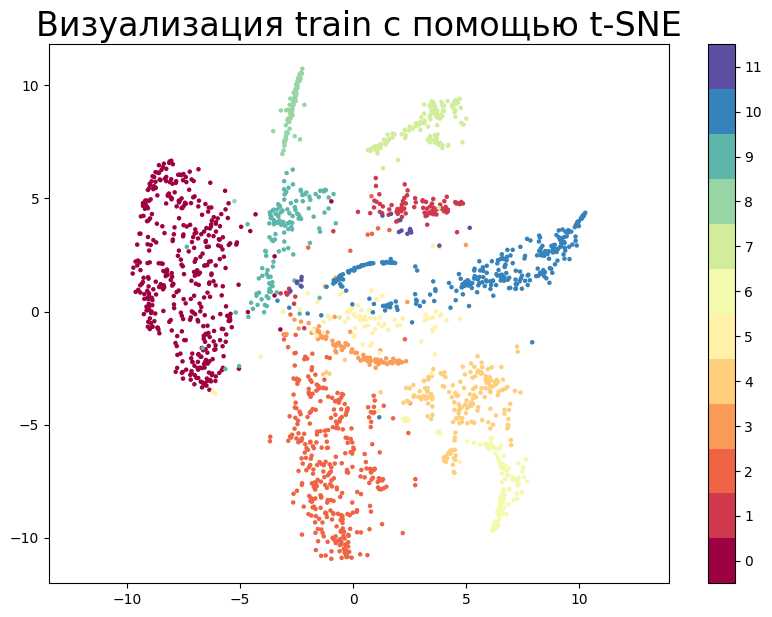

In [23]:
y_pred_train, id_train = get_predictions(model, train_loader)
y_pred_train = y_pred_train[np.argsort(id_train)]
id_train.sort()
y_pred_train = y_pred_train[:2000]
id_train = id_train[:2000]

tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred_train)

plt.figure(figsize=(10,7))

plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=id_train, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.title('Визуализация train с помощью t-SNE', fontsize=24);

С трейном у модели больших сложностей не возникло, группы четко отделены друг от друга

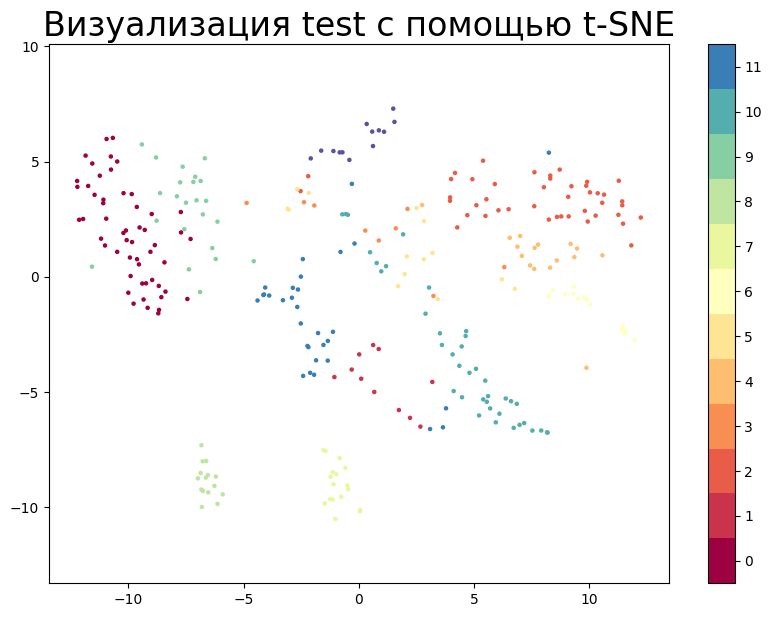

In [24]:
y_pred_test, id_test = get_predictions(model, test_loader)
y_pred_test = y_pred_test[np.argsort(id_test)]
id_test.sort()
y_pred_test = y_pred_test[:300]
id_test = id_test[:300]

tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred_test)

plt.figure(figsize=(10,7))

plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=id_test, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.title('Визуализация test с помощью t-SNE', fontsize=24);

С тестом ситуация тоже приемлимая

In [25]:
data_test = datasets.ImageFolder('./dataset_test', transform=resnet_transforms)
loader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=False)

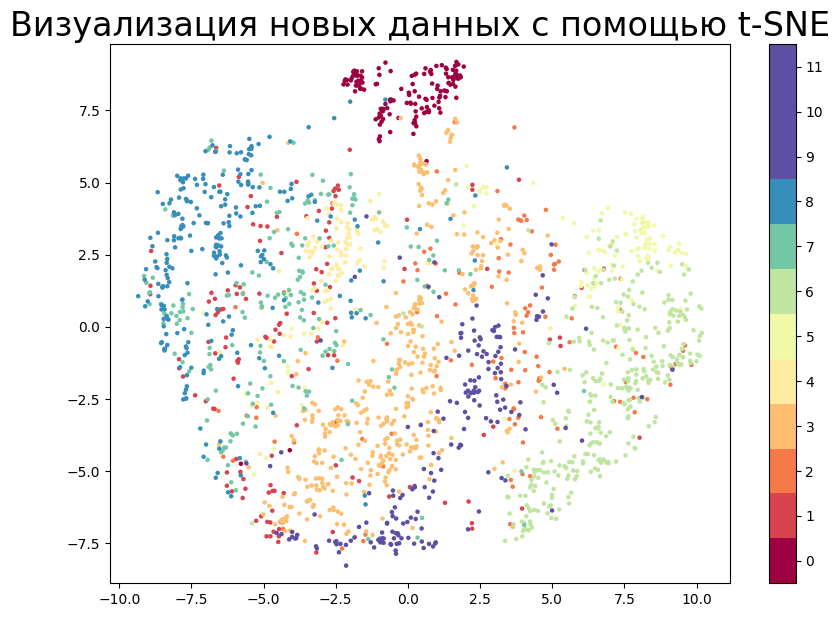

In [26]:
y_pred_test, id_test = get_predictions(model, loader)
y_pred_test = y_pred_test[np.argsort(id_test)]
id_test.sort()
y_pred_test = y_pred_test
id_test = id_test

tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred_test)

plt.figure(figsize=(10,7))

plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=id_test, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.title('Визуализация новых данных с помощью t-SNE', fontsize=24);

А вот с новыми данными есть вопросы. Модель примерно понимает, что это нечто новое, однако разделяет не очень хорошо. Можно попробовать решить эту проблему увеличением трейн выборки, или попробовать второй подход с l3 метрикой.

In [ ]:
url = 'https://drive.google.com/uc?id=1Ci7qFrOfLo5E1OGqdkBVp0X6T-LMXy54'
output = 'dataset_all.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Ci7qFrOfLo5E1OGqdkBVp0X6T-LMXy54
To: /content/dataset_all.zip
100%|██████████| 4.96G/4.96G [01:05<00:00, 76.2MB/s]


'dataset_all.zip'

In [ ]:
! unzip -qq dataset_all.zip

In [ ]:
data_all = datasets.ImageFolder('./dataset', transform=resnet_transforms)
loader_all = torch.utils.data.DataLoader(data_all, batch_size=64, shuffle=False)

In [ ]:
with open('id_names.pickle', 'wb') as f:
    pickle.dump(data_all.class_to_idx, f)

In [ ]:
y_pred_all, id_all = get_predictions(model, loader_all)

In [ ]:
np.save('vectors.npy', y_pred_all, allow_pickle=True)
np.save('id.npy', id_all, allow_pickle=True)

## Вывод

Модель с бекбоном resnet18(224,224,3) с предобученными весами, а так же головой из двух полносвязных слоев (512, 512), (512, 208) обучали на 75% выборки из 43759 изображений по батчам размером 64 с оптимизатором adam на 10 эпохах. Достигнута наибольшая метрика accuracy на 6 эпохе, на тесте 0.67.

После у этой модели срезали последний слой и оценивали разреженность вектороного пространства авторов с помощью t-sne. Модель неплохо себя проявляет с картинами, авторов которых она уже видела, однако с новыми авторами хорошего разрежения не наблюдается.

Можно попробовать решить эту проблему увеличением трейн выборки, или попробовать второй подход с l3 метрикой.

В дальнейшем, при хорошем разрежении будет обучен rnn алгоритм распознавания и будет реализованно добавление новых авторов в него.